## local lossess (all - 009)

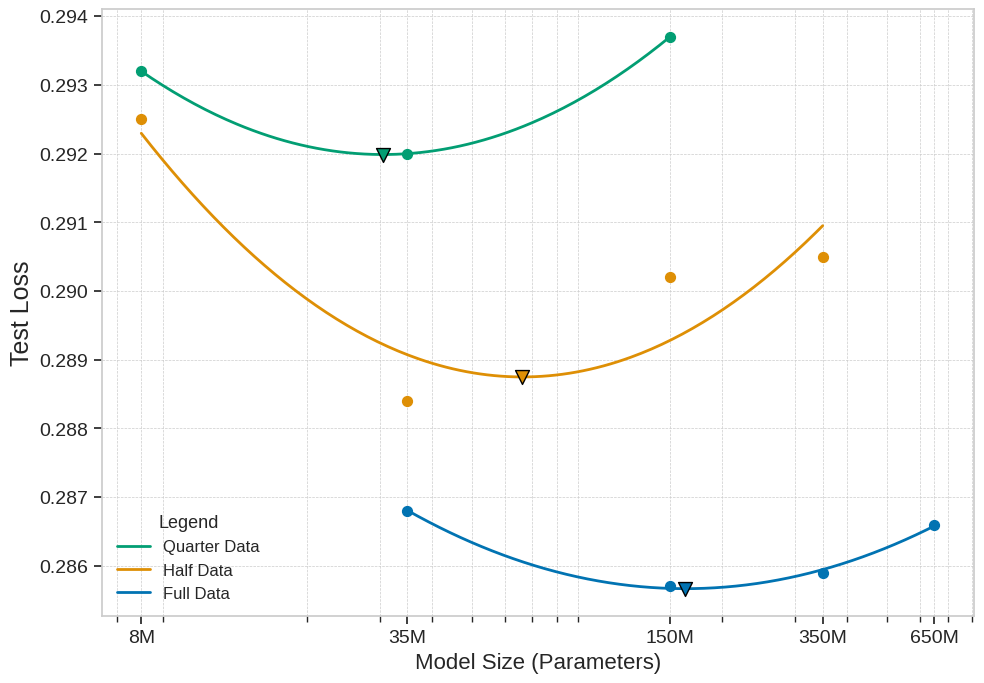

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ——— Data ———
parameters = [8e6, 35e6, 150e6, 350e6, 650e6]
parameters_labels = ['8M', '35M', '150M', '350M', '650M']
datasets = ["Quarter Data", "Half Data", "Full Data"]

evaluation_losses = {
    "Quarter Data": [0.2932, 0.2920, 0.2937, 0.2938, 0.2942],
    "Half Data":    [0.2925, 0.2884, 0.2902, 0.2905, 0.2895],
    "Full Data":    [0.2903, 0.2868, 0.2857, 0.2859, 0.2866],
}

# ——— Which points to fit on and to plot? ———
subset_indices = {
    "Quarter Data": slice(0, 3),   # keep only 8M, 35M, 150M
    "Half Data":    slice(0, 4),   # keep only 8M, 35M, 150M, 350M
    "Full Data":    slice(1, None), # keep only 35M,150M,350M,650M
}

# ——— Fit & find minimum-in-range ———
min_loss_points = {}
for ds in datasets:
    idx = subset_indices[ds]
    ps = np.array(parameters)[idx]
    ls = np.array(evaluation_losses[ds])[idx]
    logp = np.log10(ps)

    # 2nd-degree fit
    coeffs = np.polyfit(logp, ls, deg=2)
    a, b, c = coeffs
    poly = np.poly1d(coeffs)

    # Find minimum within the fitted interval
    if abs(a) < 1e-9: # Essentially linear
        ends = [poly(logp[0]), poly(logp[-1])]
        i_min = np.argmin(ends)
        # Use the parameter corresponding to the minimum loss end
        min_p, min_l = (ps[0], ends[0]) if i_min == 0 else (ps[-1], ends[1])
    elif a > 0: # Parabola opens upwards, minimum exists
        logp_min = -b / (2 * a)
        # Check if the theoretical minimum is within the fitted range
        if logp_min < logp[0]:
            min_p, min_l = ps[0], poly(logp[0])
        elif logp_min > logp[-1]:
             min_p, min_l = ps[-1], poly(logp[-1])
        else:
             min_p, min_l = 10**logp_min, poly(logp_min)
    else: # Parabola opens downwards, minimum is at one end
        loss_start, loss_end = poly(logp[0]), poly(logp[-1])
        if loss_start < loss_end:
            min_p, min_l = ps[0], loss_start
        else:
            min_p, min_l = ps[-1], loss_end

    min_loss_points[ds] = {
        'coeffs': coeffs,
        'logp_fit': logp,
        'min_param': min_p,
        'min_loss':  min_l
    }

# ——— Plot ———
sns.set_context("notebook")
palette = dict(zip(datasets[::-1],
                   sns.color_palette("colorblind", 3).as_hex()))

plt.figure(figsize=(10, 7))
for ds in datasets:
    idx = subset_indices[ds]
    ps = np.array(parameters)[idx]
    ls = np.array(evaluation_losses[ds])[idx]
    lp = min_loss_points[ds]['logp_fit']
    a, b, c = min_loss_points[ds]['coeffs']
    poly = np.poly1d((a, b, c))

    # plot only the subset of raw points (NO LABEL for legend)
    plt.scatter(ps, ls,
                color=palette[ds], s=50) # Removed label

    # fitted curve over exactly those points
    smooth = np.linspace(lp.min(), lp.max(), 200)
    plt.plot(10**smooth, poly(smooth),
             color=palette[ds], linewidth=2,
             label=f"{ds}") # MODIFIED label

    # mark the minimum within that interval
    mp = min_loss_points[ds]['min_param']
    ml = min_loss_points[ds]['min_loss']
    plt.scatter([mp], [ml],
                marker='v', edgecolor='black',
                s=100, color=palette[ds], zorder=5)

# cosmetics
plt.xscale("log")
plt.xticks(parameters, parameters_labels, fontsize=14)
plt.xlabel("Model Size (Parameters)", fontsize=16)
plt.ylabel("Test Loss", fontsize=18)
plt.tick_params(axis='y', labelsize=14)
# MODIFIED legend position and removed dot explanations
plt.legend(fontsize=12, title="Legend", title_fontsize=13, loc='lower left')
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig('lossـreg.png', dpi=300, bbox_inches='tight')
plt.show() 

## Projection plot based on the last plot

--- Input Data (Sorted by Model Size) ---
   Model Size  Data Size
0    30500000     412182
1    66200000     824363
2   163000000    1648726
Point Labels (correspond to sorted points): ['Q', 'H', 'F']
------------------------------

--- Linear Regression Results (on original scale) ---
  Slope (m): 9.1612e-03
  Intercept (c): 1.6870e+05
  R-squared (R²): 0.9951
  P-value: 0.0446
  Standard Error of Slope: 6.4301e-04

Equation: Data Size ≈ (9.1612e-03 * Model Size) + 1.6870e+05
------------------------------

--- Prediction ---
Model Size for Prediction: 6.50e+08 parameters (650 Million)
Predicted Required Data Size: Approximately 6,123,492 sequences (based on linear fit)
------------------------------

--- Plotting (Log Scale with Custom Ticks) ---
Generating log-log scale plot (may appear in a separate window)...


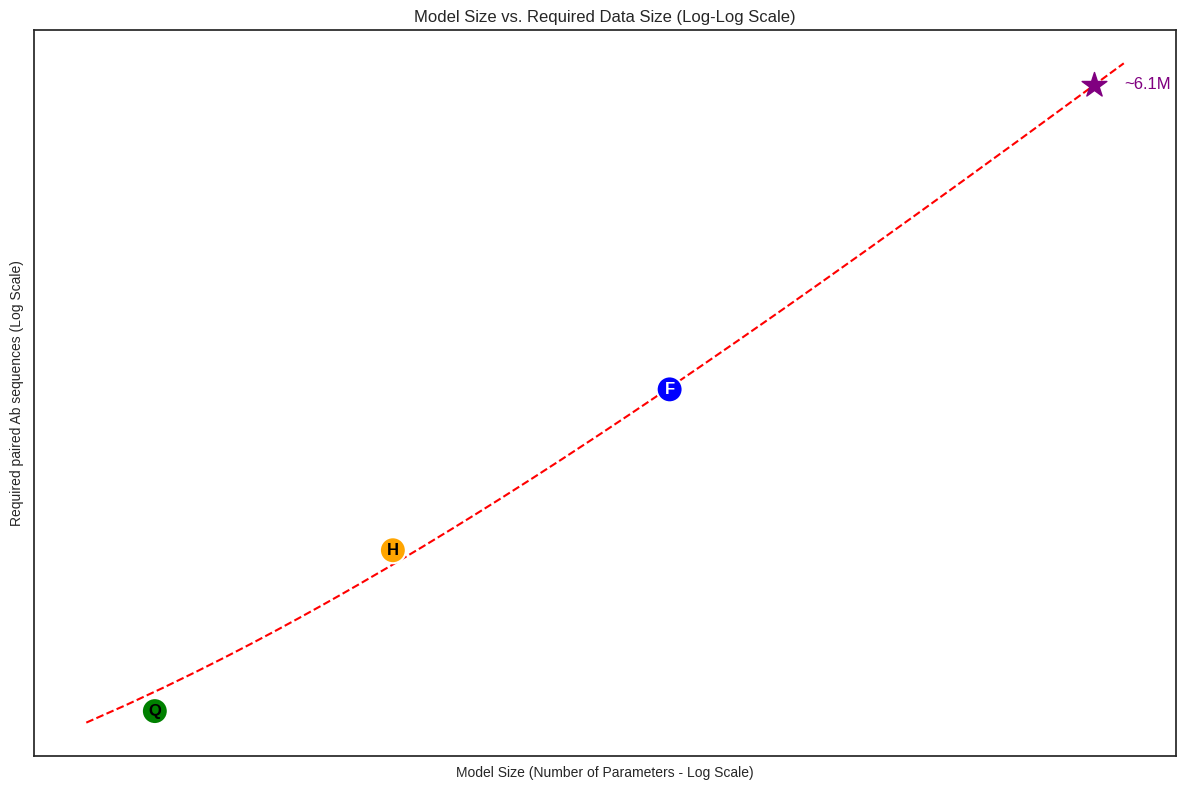

------------------------------

Reminder: This prediction is based on a LINEAR model fitted to only three data points.
The log-log plot helps visualize the data distribution, but the prediction still uses the linear fit.
If the data looks linear on the log-log plot, a power law model might be more appropriate.
The current prediction involves extrapolation. Use with caution.
------------------------------


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from matplotlib.lines import Line2D # Needed for custom legend
from matplotlib.ticker import FuncFormatter, LogFormatterSciNotation # Needed for custom tick labels

# --- 1. Data Definition ---
# Original data points provided by the user
model_size = np.array([30500000, 66200000, 163000000]) # Parameters
data_size = np.array([412182, 824363, 1648726])       # Sequences

# Create a DataFrame and sort by Model Size
df = pd.DataFrame({'Model Size': model_size, 'Data Size': data_size}).sort_values('Model Size').reset_index(drop=True)
point_labels = ['Q', 'H', 'F'] # Labels for the sorted points (will map to new legend labels)

print("--- Input Data (Sorted by Model Size) ---")
print(df)
print(f"Point Labels (correspond to sorted points): {point_labels}")
print("-" * 30)

# --- 2. Linear Regression (on original linear data) ---
# Note: Regression is still performed on the original linear values.
# The line will appear curved on the log-log plot.
slope, intercept, r_value, p_value, std_err = linregress(df['Model Size'], df['Data Size'])

print("\n--- Linear Regression Results (on original scale) ---")
print(f"  Slope (m): {slope:.4e}")
print(f"  Intercept (c): {intercept:.4e}")
print(f"  R-squared (R²): {r_value**2:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Standard Error of Slope: {std_err:.4e}")
print(f"\nEquation: Data Size ≈ ({slope:.4e} * Model Size) + {intercept:.4e}")
print("-" * 30)

# --- 3. Prediction Calculation ---
new_model_size = 6.5e8 # 650 million parameters
predicted_data_size = (slope * new_model_size) + intercept

print("\n--- Prediction ---")
print(f"Model Size for Prediction: {new_model_size:.2e} parameters (650 Million)")
print(f"Predicted Required Data Size: Approximately {predicted_data_size:,.0f} sequences (based on linear fit)")
print("-" * 30)

# --- 4. Plotting ---
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(12, 8)) # Increased height slightly for log scale
ax = plt.gca() # Get current axes object ***** ADDED *****

# Define color and new legend label mappings
palette = {'Q': 'green', 'H': 'orange', 'F': 'blue'}
legend_label_map = {'Q': 'Quarter data', 'H': 'Half data', 'F': 'Full data'}

# Scatter plot of the original data points
point_colors = [palette[label] for label in point_labels]
sns.scatterplot(x='Model Size', y='Data Size', data=df, s=350,
                color=point_colors,
                zorder=5, ax=ax) # Pass ax object

# Add text labels (Q, H, F) and dashed lines
for i in range(df.shape[0]):
    x_coord = df['Model Size'][i]
    y_coord = df['Data Size'][i]
    label = point_labels[i]

    # Set text color based on label ('F' is white, others black)
    text_color = 'white' if label == 'F' else 'black'

    # Add letter label ON the dot
    ax.text(x_coord, y_coord, label, # Use ax.text
             fontsize=12, color=text_color,
             ha='center', va='center',
             fontweight='bold', zorder=6)

# Generate points for the regression line (plotted on log scale)
x_min_plot = df['Model Size'].min() * 0.8
x_max_plot = max(df['Model Size'].max() * 1.1, new_model_size * 1.1)
x_line = np.linspace(x_min_plot, x_max_plot, 200)
y_line = slope * x_line + intercept

# Filter out non-positive y_line values if intercept is negative and x is small
positive_y_indices = y_line > 0
x_line_pos = x_line[positive_y_indices]
y_line_pos = y_line[positive_y_indices]

# Plot the linear regression line (will appear curved on log-log)
ax.plot(x_line_pos, y_line_pos, color='red', linestyle='--', label=f'Linear Fit (R²={r_value**2:.2f})', zorder=3) # Use ax.plot

# Plot the prediction point
ax.scatter(new_model_size, predicted_data_size, # Use ax.scatter
            marker='*', s=350, color='purple', zorder=7, label='Prediction (Linear Fit)')

# Add text label for the prediction point
ax.text(new_model_size * 1.1, predicted_data_size, # Use ax.text
         f"~{predicted_data_size/1e6:.1f}M",
         fontsize=12, verticalalignment='center', color='purple', zorder=8)

# --- SET LOG SCALE ---
ax.set_xscale('log') # Use ax.set_xscale
ax.set_yscale('log') # Use ax.set_yscale

# --- CUSTOM TICK FORMATTING TO HIDE SPECIFIC LABELS --- ***** ADDED BLOCK *****
# Use a default formatter to handle standard labels
default_log_formatter = LogFormatterSciNotation()

# Custom function for x-axis ticks
def custom_x_formatter_func(x, pos):
    # Check if the value is close to 1e8 (100 Million)
    if np.isclose(x, 1e8):
        return ""  # Return empty string to hide label
    else:
        return default_log_formatter(x, pos) # Use default for others

# Custom function for y-axis ticks
def custom_y_formatter_func(y, pos):
    # Check if the value is close to 1e6 (1 Million)
    if np.isclose(y, 1e6):
        return ""  # Return empty string to hide label
    else:
        return default_log_formatter(y, pos) # Use default for others

# Apply the custom formatters to the major axes
ax.xaxis.set_major_formatter(FuncFormatter(custom_x_formatter_func))
ax.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter_func))
# --- END CUSTOM TICK FORMATTING BLOCK --- *****

# Add labels and title
ax.set_xlabel("Model Size (Number of Parameters - Log Scale)") # Use ax.set_xlabel
ax.set_ylabel("Required paired Ab sequences (Log Scale)") # Use ax.set_ylabel
ax.set_title("Model Size vs. Required Data Size (Log-Log Scale)") # Use ax.set_title

# --- Legend handling (commented out as in original) ---
# # Custom legend for data points
# legend_elements = [Line2D([0], [0], marker='o', color='w',
#                            label=legend_label_map[label],
#                            markerfacecolor=palette[label], markersize=10)
#                    for i, label in enumerate(point_labels)]
# # Combine legends (data points, regression line, prediction)
# handles, labels = ax.get_legend_handles_labels() # Use ax.get_legend_handles_labels
# combined_handles = legend_elements + handles
# combined_labels = [h.get_label() for h in legend_elements] + labels
# ax.legend(handles=combined_handles, labels=combined_labels, title="Legend", loc='best') # Use ax.legend

# --- Grid handling (commented out as in original) ---
#ax.grid(True, which="both", ls="--", c='0.7') # Use ax.grid

plt.tight_layout() # Use plt.tight_layout

# Display the plot
print("\n--- Plotting (Log Scale with Custom Ticks) ---")
print("Generating log-log scale plot (may appear in a separate window)...")
#plt.savefig("model_vs_data_loglog.png", dpi=300, bbox_inches='tight') # Use plt.savefig
plt.show() # Use plt.show
print("-" * 30)

# --- 5. Prediction Reminder ---
print("\nReminder: This prediction is based on a LINEAR model fitted to only three data points.")
print("The log-log plot helps visualize the data distribution, but the prediction still uses the linear fit.")
print("If the data looks linear on the log-log plot, a power law model might be more appropriate.")
print("The current prediction involves extrapolation. Use with caution.")
print("-" * 30)

## Full regression plots 

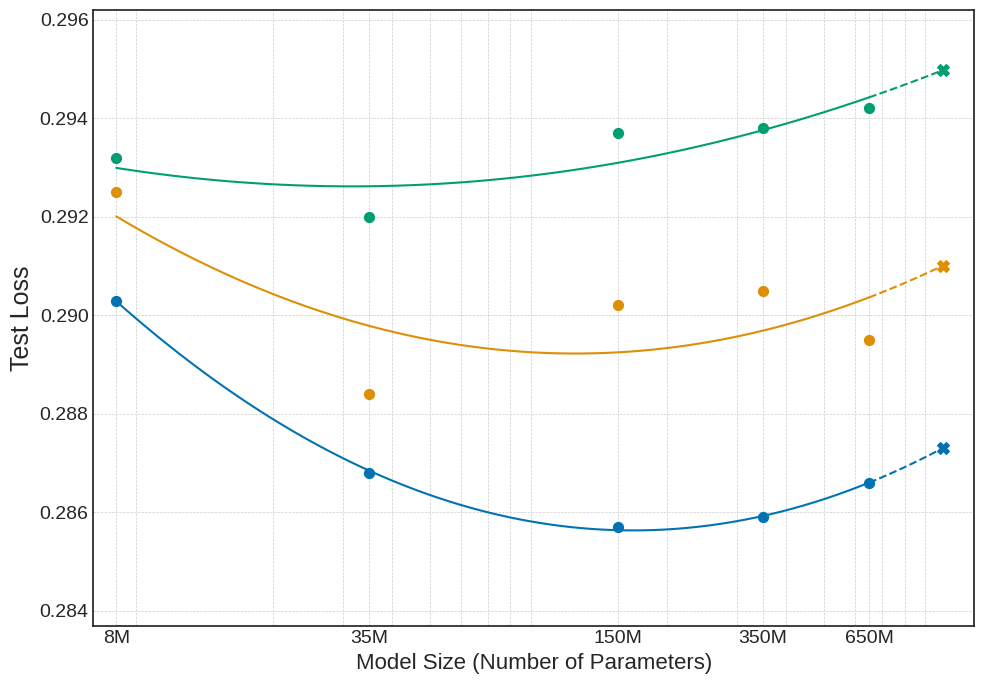

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import seaborn for the colorblind palette

# Data
parameters = [8e6, 35e6, 150e6, 350e6, 650e6]  # Model sizes in number of parameters
parameters_labels = ['8M', '35M', '150M', '350M', '650M']  # Corresponding labels
datasets = ["Quarter Data", "Half Data", "Full Data"]  # Dataset sizes (Note the order)

# Reverse the datasets list to match the order of colors
datasets_reversed = datasets[::-1]  # ['Full Data', 'Half Data', 'Quarter Data']

# Prediction point beyond the last model size
prediction_param = 1e9  # Predict for 1,000,000,000 parameters (1B)

# Evaluation losses for batch size 128 (UPDATED VALUES)
evaluation_losses = {
    "Quarter Data": [0.2932, 0.292, 0.2937, 0.2938, 0.2942],
    "Half Data":    [0.2925, 0.2884, 0.2902, 0.2905, 0.2895],
    "Full Data":    [0.2903, 0.2868, 0.2857, 0.2859, 0.2866],
}

# Get the seaborn 'colorblind' palette with 3 colors
custom_palette = sns.color_palette("colorblind", n_colors=3).as_hex()

# Map the datasets to colors based on the order in 'custom_palette'
colors = dict(zip(datasets_reversed, custom_palette))

# Create the plot
plt.figure(figsize=(10, 7))

for dataset in datasets:
    losses = evaluation_losses[dataset]

    # Convert parameters to log scale for smoother fitting
    log_params = np.log10(parameters)
    log_losses = np.array(losses)

    # Polynomial regression (2nd degree)
    poly_fit = np.polyfit(log_params, log_losses, deg=2)
    poly_line = np.poly1d(poly_fit)

    # Generate smooth lines for plotting
    smooth_log_params_data = np.linspace(log_params.min(), log_params.max(), 100)
    smooth_losses_data = poly_line(smooth_log_params_data)

    smooth_log_params_extrap = np.linspace(log_params.max(), np.log10(prediction_param), 100)
    smooth_losses_extrap = poly_line(smooth_log_params_extrap)

    # Plot original data points
    plt.scatter(parameters, losses, color=colors[dataset], marker='o', s=50)

    # Plot regression line over data range (solid line)
    plt.plot(10 ** smooth_log_params_data, smooth_losses_data, color=colors[dataset], linestyle='-', label=dataset)

    # Plot regression line over extrapolated range (dotted line)
    plt.plot(10 ** smooth_log_params_extrap, smooth_losses_extrap, color=colors[dataset], linestyle='--')

    # Plot the predicted point at prediction_param
    pred_log_param = np.log10(prediction_param)
    pred_loss = poly_line(pred_log_param)

    plt.scatter([prediction_param], [pred_loss], color=colors[dataset], marker='X', s=70, label=f'{dataset} Prediction')

# Customize the plot
plt.xscale("log")

# Set x-axis ticks and labels, excluding "1B"
xticks_positions = parameters # Remove prediction_param from x-axis labels
xticks_labels = parameters_labels
plt.xticks(xticks_positions, xticks_labels, fontsize=14) # Larger font size

plt.xlabel("Model Size (Number of Parameters)", fontsize=16)
plt.ylabel("Test Loss", fontsize=18)
# Set y-axis numbers font size
plt.tick_params(axis='y', labelsize=14) # Change font size for y-axis numbers


#plt.legend(title="Dataset Size and Predictions", fontsize=12.5, title_fontsize=14) # Larger legend text
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust Y-axis limits based on the new data range
min_loss = min(min(v) for v in evaluation_losses.values())
max_loss = max(max(v) for v in evaluation_losses.values())
plt.ylim(min_loss - 0.002, max_loss + 0.002) # Adjust ylim slightly around data range
# Example static limits if preferred: plt.ylim(0.284, 0.296)

plt.xlim(7e6, 1.2e9)

plt.tight_layout()
#plt.savefig('test_loss_updated_new_new.png', format='png', dpi=300) # Changed filename slightly
plt.show()

## full plot with error bars

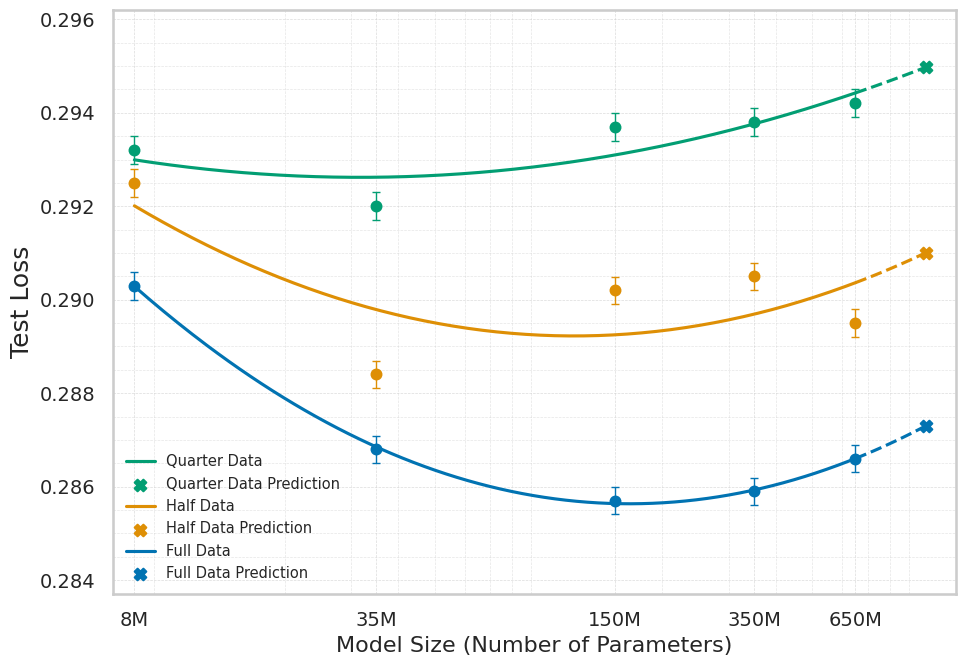

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # for the colorblind palette

# Data
parameters = [8e6, 35e6, 150e6, 350e6, 650e6]
parameters_labels = ['8M', '35M', '150M', '350M', '650M']
datasets = ["Quarter Data", "Half Data", "Full Data"]

# Evaluation losses
evaluation_losses = {
    "Quarter Data": [0.2932, 0.2920, 0.2937, 0.2938, 0.2942],
    "Half Data":    [0.2925, 0.2884, 0.2902, 0.2905, 0.2895],
    "Full Data":    [0.2903, 0.2868, 0.2857, 0.2859, 0.2866],
}

# Standard errors (tiny bars) – interpreted as 0.0003-scale
se_errors = {
    "Quarter Data": [0.000299, 0.000296, 0.000299, 0.000299, 0.000299],
    "Half Data":    [0.000296, 0.000292, 0.000296, 0.000296, 0.000294],
    "Full Data":    [0.000296, 0.000291, 0.000290, 0.000290, 0.000291],
}

# Prediction beyond your last point
prediction_param = 1e9  # 1B parameters

# Set up a colorblind‐friendly palette
custom_palette = sns.color_palette("colorblind", n_colors=3).as_hex()
# To keep your original ordering but match palette, reverse first
colors = dict(zip(datasets[::-1], custom_palette))

plt.figure(figsize=(10, 7))









for dataset in datasets:
    losses = evaluation_losses[dataset]
    errors = se_errors[dataset]
    
    # Fit a quadratic in log‐space
    log_p = np.log10(parameters)
    poly_coefs = np.polyfit(log_p, losses, deg=2)
    poly_fn = np.poly1d(poly_coefs)
    
    # Smooth curve over data range
    smooth_logp = np.linspace(log_p.min(), log_p.max(), 200)
    smooth_losses = poly_fn(smooth_logp)
    
    # Extrapolate to 1B
    smooth_logp_pred = np.linspace(log_p.max(), np.log10(prediction_param), 100)
    smooth_losses_pred = poly_fn(smooth_logp_pred)
    
    # Plot the regression curve
    plt.plot(10**smooth_logp,       smooth_losses,      color=colors[dataset], linestyle='-',
             label=f"{dataset}")
    plt.plot(10**smooth_logp_pred,  smooth_losses_pred, color=colors[dataset], linestyle='--')
    
    # Plot error bars (no marker here)
    plt.errorbar(parameters, losses,
                 yerr=errors,
                 fmt='none',
                 ecolor=colors[dataset],
                 elinewidth=1,
                 capsize=3)
    
    # Plot the mean points on top
    plt.scatter(parameters, losses,
                color=colors[dataset],
                marker='o',
                s=50)
    
    # Plot the predicted X‐marker
    pred_loss = poly_fn(np.log10(prediction_param))
    plt.scatter([prediction_param], [pred_loss],
                color=colors[dataset],
                marker='X',
                s=70,
                label=f"{dataset} Prediction")

# Log scale, ticks, labels
plt.xscale("log")
plt.xticks(parameters, parameters_labels, fontsize=14)
plt.xlabel("Model Size (Number of Parameters)", fontsize=16)
plt.ylabel("Test Loss", fontsize=18)
plt.tick_params(axis='y', labelsize=14)
#plt.axvspan(650e6, 1.2e9, color='gray', alpha=0.1, label="extrapolation region")


plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.7)
plt.grid(which="minor", linestyle=":", linewidth=0.3, alpha=0.5)
plt.minorticks_on()


# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, 
#            title="Dataset & Predictions")




plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Y limits just beyond your min/max
all_losses = sum(evaluation_losses.values(), [])
plt.ylim(min(all_losses) - 0.002, max(all_losses) + 0.002)
plt.xlim(7e6, 1.2e9)




sns.set_style("whitegrid")
sns.set_context("talk")  # makes font large and lines thicker



plt.legend( fontsize=10.5, title_fontsize=10)
plt.tight_layout()
plt.savefig('test_loss_plot.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


--- Input Data (Sorted by Model Size) ---
   Model Size  Data Size
0    30500000     412182
1    66200000     824363
2   163000000    1648726
Point Labels (correspond to sorted points): ['Q', 'H', 'F']
------------------------------

--- Linear Regression Results (on original scale) ---
  Slope (m): 9.1612e-03
  Intercept (c): 1.6870e+05
  R-squared (R^2): 0.9951
  P-value: 0.0446
  Standard Error of Slope: 6.4301e-04

Equation: Data Size ≈ (9.1612e-03 * Model Size) + 1.6870e+05
------------------------------

--- Prediction ---
Model Size for Prediction: 6.50e+08 parameters (650 Million)
Predicted Required Data Size: Approximately 6,123,492 sequences (based on linear fit)
------------------------------

--- Plotting (Log Scale with Detailed Ticks and Annotations) ---
Generating log-log scale plot (may appear in a separate window)...


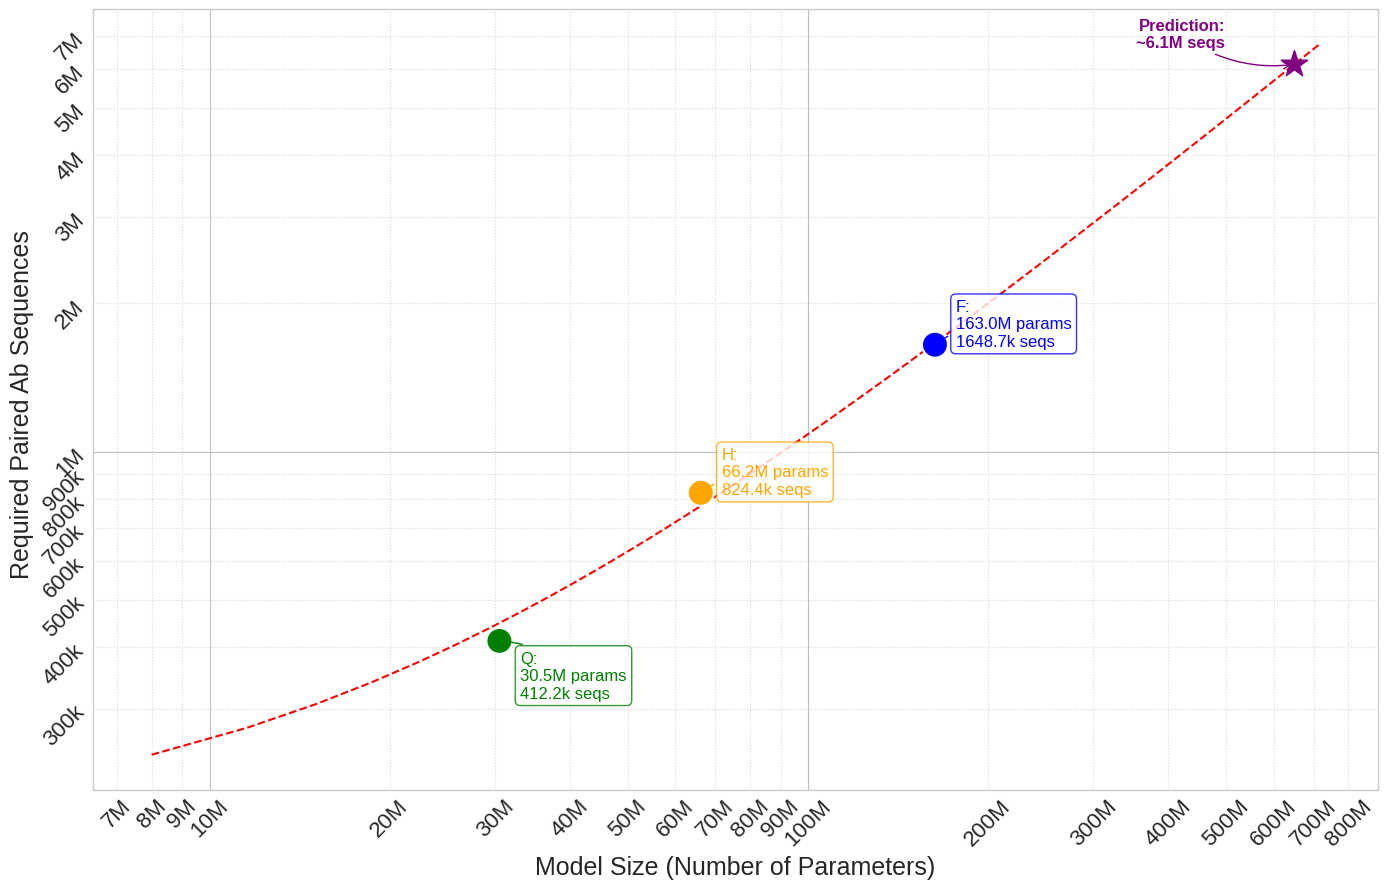

------------------------------

Reminder: This prediction is based on a LINEAR model fitted to only three data points.
The log-log plot helps visualize the data distribution, but the prediction still uses the linear fit.
If the data appears linear on the log-log plot, a power law model (linear regression on log-transformed data) might be more appropriate.
The current prediction involves extrapolation. Use with caution.
------------------------------


In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter, LogLocator, NullFormatter # Import LogLocator and NullFormatter

# --- 1. Data Definition ---
# Original data points provided by the user
model_size = np.array([30500000, 66200000, 163000000]) # Parameters
data_size = np.array([412182, 824363, 1648726])       # Sequences

# Create a DataFrame and sort by Model Size
df = pd.DataFrame({'Model Size': model_size, 'Data Size': data_size}).sort_values('Model Size').reset_index(drop=True)
point_labels = ['Q', 'H', 'F'] # Labels for the sorted points

print("--- Input Data (Sorted by Model Size) ---")
print(df)
print(f"Point Labels (correspond to sorted points): {point_labels}")
print("-" * 30)

# --- 2. Linear Regression (on original linear data) ---
slope, intercept, r_value, p_value, std_err = linregress(df['Model Size'], df['Data Size'])

print("\n--- Linear Regression Results (on original scale) ---")
print(f"  Slope (m): {slope:.4e}")
print(f"  Intercept (c): {intercept:.4e}")
# Use R^2 or R-squared in print statements instead of the special character ²
print(f"  R-squared (R^2): {r_value**2:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Standard Error of Slope: {std_err:.4e}")
print(f"\nEquation: Data Size ≈ ({slope:.4e} * Model Size) + {intercept:.4e}")
print("-" * 30)

# --- 3. Prediction Calculation ---
new_model_size = 6.5e8 # 650 million parameters
predicted_data_size = (slope * new_model_size) + intercept

if predicted_data_size <= 0:
    print("\n--- Warning ---")
    print("Predicted data size is non-positive based on linear fit. Cannot plot prediction point on log scale.")
    print("-" * 30)
    plot_prediction = False
else:
    plot_prediction = True
    print("\n--- Prediction ---")
    print(f"Model Size for Prediction: {new_model_size:.2e} parameters (650 Million)")
    print(f"Predicted Required Data Size: Approximately {predicted_data_size:,.0f} sequences (based on linear fit)")
    print("-" * 30)


# --- 4. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 9))
ax = plt.gca()

palette = {'Q': 'green', 'H': 'orange', 'F': 'blue'}
point_colors = [palette[label] for label in point_labels]

sns.scatterplot(x='Model Size', y='Data Size', data=df, s=350,
                color=point_colors,
                zorder=5, ax=ax, legend=False)

annotation_offsets = {'Q': (15, -25), 'H': (15, 15), 'F': (15, 15)}
for i in range(df.shape[0]):
    x_coord = df['Model Size'][i]
    y_coord = df['Data Size'][i]
    label = point_labels[i]
    color = palette[label]
    offset = annotation_offsets[label]
    annotation_text = (
        f"{label}:\n"
        f"{x_coord/1e6:.1f}M params\n"
        f"{y_coord/1e3:.1f}k seqs"
    )
    ax.annotate(annotation_text,
                xy=(x_coord, y_coord), xytext=offset, textcoords='offset points',
                fontsize=12, color=color, ha='left', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.8),
                arrowprops=dict(arrowstyle="->", color=color, connectionstyle="arc3,rad=0.2"),
                zorder=6)

# Generate points for the regression line
x_min_plot = min(df['Model Size'].min() * 0.8, 8e6) # Start around 8M
x_max_plot = max(df['Model Size'].max() * 1.1, new_model_size * 1.1)
x_line = np.linspace(x_min_plot, x_max_plot, 200)
y_line = slope * x_line + intercept
positive_y_indices = y_line > 0
x_line_pos = x_line[positive_y_indices]
y_line_pos = y_line[positive_y_indices]

if len(x_line_pos) > 1:
    # Keep R² in the plot label as Matplotlib usually handles it
    ax.plot(x_line_pos, y_line_pos, color='red', linestyle='--', label=f'Linear Fit (R²={r_value**2:.2f})', zorder=3)
else:
    print("Warning: Not enough positive points to plot the regression line on the log scale.")

if plot_prediction:
    ax.scatter(new_model_size, predicted_data_size,
               marker='*', s=400, color='purple', zorder=7, label='Prediction (650M params)')

    # Use annotate with an offset so the text sits right by the star
    ax.annotate(
        f"Prediction:\n~{predicted_data_size/1e6:.1f}M seqs",
        xy=(new_model_size, predicted_data_size),
        xytext=(-50, 10),              # 50 points left, 20 points up
        textcoords='offset points',
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        color='purple',
        fontweight='bold',
        zorder=12,
        arrowprops=dict(
            arrowstyle="->",
            color='purple',
            connectionstyle="arc3,rad=0.2"
        )
    )


# --- SET LOG SCALE ---
ax.set_xscale('log')
ax.set_yscale('log')

# --- REVISED TICK FORMATTING AND LOCATING ---

# Custom readable formatter function (handles k, M, G)
def readable_log_formatter_func(val, pos):
    if val >= 1e9:
        if np.isclose(val / 1e9, round(val / 1e9)): return f'{round(val / 1e9):.0f}G'
        else: return f'{val / 1e9:.1f}G'
    elif val >= 1e6:
        if np.isclose(val / 1e6, round(val / 1e6)): return f'{round(val / 1e6):.0f}M'
        else: return f'{val / 1e6:.1f}M'
    elif val >= 1e3:
        if np.isclose(val / 1e3, round(val / 1e3)): return f'{round(val / 1e3):.0f}k'
        else: return f'{val / 1e3:.1f}k'
    else:
        if np.isclose(val, round(val)): return f'{round(val):.0f}'
        else: return f'{val:.1f}'

# Apply the custom formatter to MAJOR ticks
ax.xaxis.set_major_formatter(FuncFormatter(readable_log_formatter_func))
ax.yaxis.set_major_formatter(FuncFormatter(readable_log_formatter_func))

# Explicitly set MAJOR tick locations (powers of 10)
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=15)) # numticks is approximate
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))

# Explicitly set MINOR tick locations (e.g., 2, 3, ..., 9 within each decade)
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=15))

# Format MINOR ticks using the same readable formatter (can be crowded)
ax.xaxis.set_minor_formatter(FuncFormatter(readable_log_formatter_func))
ax.yaxis.set_minor_formatter(FuncFormatter(readable_log_formatter_func))
# To hide minor tick labels (less clutter):
# ax.xaxis.set_minor_formatter(NullFormatter())
# ax.yaxis.set_minor_formatter(NullFormatter())


# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=16,labelrotation=45)
ax.tick_params(axis='x', which='minor', labelsize=16, labelrotation=45) # Rotate minor x-labels
ax.tick_params(axis='y', which='minor', labelsize=16, labelrotation=45)
# --- END TICK FORMATTING AND LOCATING ---


# Add labels and title
ax.set_xlabel("Model Size (Number of Parameters)", fontsize=18)
ax.set_ylabel("Required Paired Ab Sequences ", fontsize=18)
#ax.set_title("Model Size vs. Required Data Size (Log-Log Scale with Linear Fit)", fontsize=14, fontweight='bold')

# --- Legend handling ---
# handles, labels = ax.get_legend_handles_labels()
# if handles:
#     ax.legend(handles=handles, labels=labels, title="Legend", loc='lower right', fontsize=10)

# --- Grid handling ---
ax.grid(True, which="major", ls="-", c='0.75') # Solid lines for major
ax.grid(True, which="minor", ls=":", c='0.85') # Dotted lines for minor

plt.tight_layout()

print("\n--- Plotting (Log Scale with Detailed Ticks and Annotations) ---")
print("Generating log-log scale plot (may appear in a separate window)...")
plt.savefig("model_vs_data_loglog_detailed_ticks.png", dpi=300, bbox_inches='tight')
plt.show()
print("-" * 30)

# --- 5. Prediction Reminder ---
print("\nReminder: This prediction is based on a LINEAR model fitted to only three data points.")
print("The log-log plot helps visualize the data distribution, but the prediction still uses the linear fit.")
print("If the data appears linear on the log-log plot, a power law model (linear regression on log-transformed data) might be more appropriate.")
print("The current prediction involves extrapolation. Use with caution.")
print("-" * 30)